# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py


from leverReconstructionFunctions import *
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import remainder, tau
import math
from scipy import stats
from statannotations.Annotator import Annotator
import collections
from matplotlib.colors import LinearSegmentedColormap

In [2]:
sns.__version__

'0.12.2'

# Preparations

In [3]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [4]:
prepareSessionsForSpatialAnalysisProject(sSessions,myProject.sessionList)

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|██████████| 180/180 [03:26<00:00,  1.15s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [5]:
def nested_dict():
    return collections.defaultdict(nested_dict)

boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,
                   'width': 0.75})
stripplot_kwargs = dict({'linewidth': 1, 'size': 7, 'alpha': 0.8},)

colors = ['#ff0080','#3f5efb','#40e0d0','#ff8c00','#ff0080']

cmap = LinearSegmentedColormap.from_list('custom',colors)

color_map_hue = 'leverAngle' 

GLOBALFONTSIZE = 13

In [6]:
useAble = [
       'jp3269-28112022-0108', 'jp452-25112022-0110', 'jp452-24112022-0109','jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108','jp451-29102022-0108', 'jp451-30102022-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107','jp452-23112022-0108', 'jp1686-26042022-0108']

In [7]:
fp = os.path.join(myProject.dataPath,'results','shuffled_lever_grid_coordinates_anchoring_strength_analysis.pickle')

with open(fp, 'rb') as file:
    shuffleData = pickle.load(file)

In [8]:
def get_shuffled_stats(lc = 'atLever_dark',param='shuffled'):
    shuffleHolder = []
    sesHolder = []
    light_condition = lc
    for s in shuffleData.keys():
        sd = shuffleData[s][light_condition][param]
        shuffleHolder.append(sd)
        sesHolder.append(s)

    shuffleLightDf = pd.DataFrame(np.array([shuffleHolder]),columns=sesHolder)
    longDf = shuffleLightDf.melt(var_name = 'Session', value_name = 'Values')
    longDf['light'] = light_condition
    return longDf

In [9]:
shuffleStatsDf = pd.concat([get_shuffled_stats('atLever_dark','predicted'),get_shuffled_stats('atLever_light','predicted')])

In [10]:
fn = os.path.join(myProject.dataPath,'results','allSessionDf_with_leverVector_and_last_cohort.csv')
allSessionDf = pd.read_csv(fn,index_col=0) 
allSessionDf['distanceToArenaCenter'] = np.sqrt(allSessionDf['xPose']**2 + allSessionDf['yPose']**2)

In [11]:
from matplotlib.colors import Normalize

hue_min = allSessionDf['leverAngle'].min()
hue_max = allSessionDf['leverAngle'].max()
GLOBALHUENORM = Normalize(vmin=hue_min, vmax=hue_max)

In [12]:
import matplotlib.patches as patches

arenaBorderColor= '#BAD7E9'
def draw_circle(ax, r=44, edge_color=arenaBorderColor, center=(0, 0), lw=2, ls='solid'):
    circle = plt.Circle(center, r, edgecolor=edge_color, facecolor='none', lw=lw, linestyle=ls, alpha=1)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
def plot_leverPath(ax,df,condition = 'atLever_dark',predicted=False,color_map_hue = 'leverAngle',simple=False,title='',ylabel=''):
    
    if predicted:
        b = sns.scatterplot(data = df[df.condition == condition], x = 'ActualCoordpx',y = 'ActualCoordpy', s =4,
                            hue = color_map_hue,hue_norm=GLOBALHUENORM,palette=cmap,alpha=1,legend=False) 
    else:    
        b = sns.scatterplot(data = df[df.condition == condition], x = 'xPose',y = 'yPose', s =4,
                            hue = color_map_hue,hue_norm=GLOBALHUENORM,palette=cmap,alpha=1,legend=False) 
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Room Coordinate X",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Room Coordinate X",fontsize=GLOBALFONTSIZE)
    

    
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    ax.set_aspect('equal')
    
    if predicted:
        ax.set_title(f'Predicted {condition}',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title(f'Actual {condition}',fontsize=GLOBALFONTSIZE)
        
    if simple == True:
        if condition == 'atLever_light':
            borderCo = '#f1d18a'
        else:
            borderCo = '#588d9c'
                
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel(ylabel, labelpad = 30,fontsize=GLOBALFONTSIZE)
        ax.set_title('')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        #Add the border of the arena
        draw_circle(ax)
        draw_circle(ax,r=40,lw=1,ls='dashed')

        ax.set_title(f"{title}",fontsize=GLOBALFONTSIZE)

        
def plot_leverCenter(ax,df,condition = 'atLever_dark',predicted=False,color_map_hue = 'leverAngle'):
    
    if predicted:
        b = sns.scatterplot(data = df[df.condition == condition], x = 'leverCenterActualpX',y = 'leverCenterActualpY', s =1,hue = color_map_hue,hue_norm=GLOBALHUENORM,
                            palette=cmap,alpha=1,legend=False) 
    else:    
        b = sns.scatterplot(data = df[df.condition == condition], x = 'leverCenterX',y = 'leverCenterY', s =1,hue = color_map_hue,hue_norm=GLOBALHUENORM,
                            palette=cmap,alpha=1,legend=False) 
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Room Coordinate X")
    ax.set_ylabel("Room Coordinate X")
    
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    if predicted:
        ax.set_title(f'Predicted {condition}')
    else:
        ax.set_title(f'Actual {condition}')

def plot_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=False,color_map_hue='leverAngle',simple=False, negativeToPositive=False,ylabel = ''):
    
    trialDf = df[df.condition == c].copy()
    
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])


    
    colorMap = cmap
    
    mask = (vCoordinates.v0 < np.pi*2)&(vCoordinates.v0 >= 0)&(vCoordinates.v1 < np.pi*2)&(vCoordinates.v1 >= 0)
    
    if negativeToPositive:
        mask = (vCoordinates.v0 < np.pi)&(vCoordinates.v0 >= -np.pi)&(vCoordinates.v1 < np.pi)&(vCoordinates.v1 >= -np.pi)
    
    a = sns.scatterplot(data=vCoordinates[mask],x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap, ax = ax,legend=False,s = 2,alpha = 1)

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid Coordinate X")
    ax.set_ylabel("Grid Coordinate Y")
    
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        
    if double:
        d = 'LOOPED'
    else:
        d = ''
    
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else: 
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0,2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        
        
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        ax.set_title('')
        
    if negativeToPositive:
        ax.set_xticks(ticks=[-np.pi, np.pi])
        ax.set_xticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, np.pi])
        ax.set_yticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        
def plot_lever_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=False,stack= False,simple=False, negativeToPositive=False,ylabel = ''):
    trialDf = df[df.condition == c].copy()
    if double:
        v0,v1 = get_double_lever_v(trialDf,predicted=predicted)
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0_l','v1_l',color_map_hue])
    else:
        v0,v1 = get_lever_v(trialDf,predicted=predicted)
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0_l','v1_l',color_map_hue])
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])
    colorMap = cmap
    
    mask = (vCoordinates_l.v0_l < np.pi*2)&(vCoordinates_l.v0_l >= 0)&(vCoordinates_l.v1_l < np.pi*2)&(vCoordinates_l.v1_l >= 0)
    
    if negativeToPositive:
        mask = (vCoordinates_l.v0_l < np.pi)&(vCoordinates_l.v0_l >= -np.pi)&(vCoordinates_l.v1_l < np.pi)&(vCoordinates_l.v1_l >= -np.pi)

    a = sns.kdeplot(data=vCoordinates_l,x = 'v0_l',y = 'v1_l',alpha = 1, fill=True, ax = ax)
    
    if stack:
        a = sns.scatterplot(data=vCoordinates,x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap, ax = ax,legend=False,s = 5)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid Coordinate X",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Grid Coordinate Y",fontsize=GLOBALFONTSIZE)
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
    if double:
        d = 'LOOPED'
    else:
        d = ''
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0, 2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        ax.set_title('')
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        
    if negativeToPositive:
        ax.set_xticks(ticks=[-np.pi, np.pi])
        ax.set_xticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, np.pi])
        ax.set_yticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)

# Vector to lever or bridge

In [13]:
def get_lever_vector_gridCoord(sessionName,cells,sSessions,inputDf):
    """
    Function used to transform the xy to v0,v1,v2 coordinate system for a session
    The direction and period of v0,v1,v2 depend on the grid cells recorded in this session.
    We get the grid parameter from .grid_cells_parameters.pkl
    """
    #Create the toLeverVector
    toLeverVector = np.array(inputDf[['vectorToLever_x','vectorToLever_y']])
    
    # load session files
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    verbose = False
    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    if verbose:
        print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
    oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in params])
    oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in params])
    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])
    periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in params])


    grid_param_transformation = {
    "period": np.median(periodFlexible,axis=0),
    "orientation": np.median(oriFlexible,axis=0),
    }

    if verbose:
        print(grid_param_transformation)

    gt = gridTransformation(period = grid_param_transformation["period"],
                           orientation = grid_param_transformation["orientation"])

    gridSpacePose = gt.poseToGridSpace(pose=np.array(toLeverVector))
    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    
    return v0, v1

def get_bridge_vector_gridCoord(sessionName,cells,sSessions,inputDf):
    """
    Function used to transform the xy to v0,v1,v2 coordinate system for a session
    The direction and period of v0,v1,v2 depend on the grid cells recorded in this session.
    We get the grid parameter from .grid_cells_parameters.pkl
    """
    #Create the toLeverVector
    toLeverVector = np.array(inputDf[['vectorToBridge_x','vectorToBridge_y']])
    
    # load session files
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    verbose = False
    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    if verbose:
        print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
    oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in params])
    oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in params])
    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])
    periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in params])


    grid_param_transformation = {
    "period": np.median(periodFlexible,axis=0),
    "orientation": np.median(oriFlexible,axis=0),
    }

    if verbose:
        print(grid_param_transformation)

    gt = gridTransformation(period = grid_param_transformation["period"],
                           orientation = grid_param_transformation["orientation"])

    gridSpacePose = gt.poseToGridSpace(pose=np.array(toLeverVector))
    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    
    return v0, v1

# Put everything in one figure

In [14]:
fn=myProject.dataPath+"/results/myLeverMapsHDInfo_new_function.pickle"
with open(fn, 'rb') as handle:
    HDInfo = pickle.load(handle)
    
fn=myProject.dataPath+"/results/myLeverMapsHDInfoShuffle100.pickle"
with open(fn, 'rb') as handle:
    HDInfoShuffle100 = pickle.load(handle)
    

fn=myProject.dataPath+"/results/leverMapCor.pickle"
with open(fn, 'rb') as handle:
    leverMapCor = pickle.load(handle)
 
fn=myProject.dataPath+"/results/leverIFRDict.pickle"
with open(fn, 'rb') as handle:
    leverIFR = pickle.load(handle)
    


fn=myProject.dataPath+"/results/cells.csv"
ct = pd.read_csv(fn)
cells = ct.copy()


gcIndices=ct["gridCell_FIRST"] 
gcId=ct.cluId[gcIndices]
print("Grid cells: {}".format(np.sum(gcIndices)))
gc=ct.loc[ct["gridCell_FIRST"],:] 
leverGc = ct.loc[ct["gridCell_FIRST"],:] 

Grid cells: 931


In [15]:
cellDict={"light": {"cellIds":["jp1686-26042022-0108_29","jp3129-04062022-0108_340",'mn8578-23122021-0108_141'],
                    "trialLists":([70,16,72],[8,18,48],[117,67,18])},
          "dark": {"cellIds": ["jp3129-04062022-0108_389","jp486-16032023-0108_653",'jp486-26032023-0108_751'],
                   "trialLists":([51,77,89],[91,75,117],[19,35,129])}
         }

In [16]:
def normalize_2d_array(arr):
    """
    Normalize the values in each row of a 2D array to the range [0, 1].

    Parameters:
    arr (list of lists): The input 2D array.

    Returns:
    np.ndarray: The normalized 2D array.
    """
    # Convert the input list of lists to a NumPy array
    np_arr = np.array(arr, dtype=float)

    # Find the minimum and maximum values along each row
    min_vals = np.min(np_arr, axis=1, keepdims=True)
    max_vals = np.max(np_arr, axis=1, keepdims=True)

    # Ensure there are no divisions by zero
    max_vals[max_vals == min_vals] = 1

    # Normalize the array to the range [0, 1]
    normalized_arr = (np_arr - min_vals) / (max_vals - min_vals)

    return normalized_arr

In [17]:
arenaBorderColor= '#BAD7E9'
def draw_circle(ax, r=44, edge_color=arenaBorderColor, center=(0, 0), lw=2, ls='solid'):
    circle = plt.Circle(center, r, edgecolor=edge_color, facecolor='none', lw=lw, linestyle=ls, alpha=1)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)

def plotAngularMap(axes, maps,bc='#000000',showYLabel=True):
    histo=gaussian_filter1d(maps['histo'], sigma=2)
    axes.plot(histo,lw=3,color=bc)
    if showYLabel:
        axes.set_ylabel("Firing\nrate (Hz)",fontsize= GLOBALFONTSIZE)
    else:
        axes.set_ylabel("")
        axes.set_yticks([])
        
    
    axes.set_xlabel("")
    axes.set_xticks([])
    [axes.spines[d].set_visible(False) for d in ['top','bottom','right']]
    
def plotLeverIFRMatrix(ax,cellId,light,showXLabel=True,sort=True,showYLabel=True,rowNorm = False):
    """
    Plot the matrix of rate per journey as a function of direction
    """
    m = leverIFR[cellId]["matrix"]['{}_targetToAnimalAngle'.format(light)]
    
    # sort matrix from shortest to longest distance from lever
    if sort:
        m["matrix"]= m["matrix"][np.argsort(-np.sum(np.isnan(m["matrix"]),axis=1))]
    if rowNorm:
        m["matrix"]=normalize_2d_array(m["matrix"])
    
    ax.imshow(m['matrix'],aspect="auto",interpolation="none",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]],origin="lower",cmap="viridis")
    
    if showXLabel:
        ax.set_xlabel("Direction",fontsize=GLOBALFONTSIZE)
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([ "-$\pi$","0", "$\pi$"])
    else:
        ax.set_xlabel("")
        ax.set_xticks([])
        
    if showYLabel:
        ax.set_ylabel("Trials",fontsize=GLOBALFONTSIZE)
    else:
        ax.set_ylabel("")
        ax.set_yticks([])
    #ax.yaxis.set_label_coords(-0.4, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_aspect('equal')
    

def plotTrialSetup(t,ax=None,title = "", arena=True, bridge=True,homeBase=True,lever=True,leverZones=True, borderColor= '#000000'):
        """
        Function to draw arena, bridge and home base on an axis
        """
        if ax is None:
            ax = plt.gca()

        # to plot the arena circle
        arenaPose=np.arange(start=0,stop=2*np.pi,step=0.02)
        # plot the arena and arena periphery
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(title,fontsize=GLOBALFONTSIZE)
        if arena:
            draw_circle(ax)
            draw_circle(ax,r=40,lw=1,ls='dashed')
            
            ax.set_xlabel("cm")
            ax.set_ylabel("cm")
        zones=[]
        if bridge:
            zones.append("bridge")
        if homeBase:
            zones.append("homeBase")
        if bridge or homeBase:
            for i in zones:
                rect = patches.Rectangle((t.zones[i][0],
                                          t.zones[i][1]), 
                                          t.zones[i][2],
                                          t.zones[i][3], linewidth=1, edgecolor='gray', facecolor='none')
                # Add the patch to the axes
                ax.add_patch(rect)
        if lever:
            
            def plotLever(t,ax=None, zones=True):
                """
                Function to plot the lever on an matplotlib axis
                """
                if ax is None:
                    ax = plt.gca()

                if hasattr(t, 'pointsPlot'):
                    ax.plot(t.pointsPlot[:,0],t.pointsPlot[:,1], color = "#525252",lw=3)
                    if zones:
                        ax.plot(t.enterZonePointsPlot[:,0],t.enterZonePointsPlot[:,1], color = "gray",linestyle="dotted")
                        ax.plot(t.exitZonePointsPlot[:,0],t.exitZonePointsPlot[:,1], color = "gray",linestyle="dotted")
                    
            plotLever(t=t.lever,ax=ax,zones=leverZones)
        return(ax)
    
def plot_correlations(gs,leverMapCor,showLegend=False):
    four_custom = [boxPlotColors[0],boxPlotColors[2]] #'#ffc600'
    ##02304A color black
    custom_pallet = sns.color_palette(four_custom)
    
    ax = fig.add_subplot(gs)

    leverMapCor=leverMapCor.replace('none','Lever ref.')
    leverMapCor=leverMapCor.replace('arenaref','Room ref.')
    b = sns.boxplot(x="condition", y="r", hue = "rotation", data=leverMapCor, palette = custom_pallet, order = ["l1l2","d1d2"], hue_order=['Lever ref.','Room ref.'],
                dodge=True, showfliers = False, **boxplot_kwargs)
    sns.stripplot(x="condition", y="r", hue = "rotation", data=leverMapCor, palette = custom_pallet, order = ["l1l2","d1d2"], hue_order=['Lever ref.','Room ref.'], dodge = True, legend=False,**stripplot_kwargs) #, legend=False
    ax.set_ylabel("Inter-trial map stability",fontsize=GLOBALFONTSIZE)
    ax.set_xlabel("")
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-0.1,1.3)
    
    sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.73,0.81),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
    
    pairs=[[("d1d2", "Lever ref."),("d1d2","Room ref.")],[("l1l2", "Lever ref."),("l1l2","Room ref.")]]

    annotator = Annotator(b, pairs, x="condition", y="r", hue = "rotation", data=leverMapCor,order = ["l1l2","d1d2"], hue_order=['Lever ref.','Room ref.'])
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(["Light", "Dark"],rotation= 0,ha = "center",fontsize=GLOBALFONTSIZE)
    
    number = len(leverMapCor.mouse.unique())
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
def boxplot_from_shuffle(gs,df_HDInfo,y,ylabel,showLegend=False):
    four_custom = [boxPlotColors[0],boxPlotColors[3]] #'#5800ff'
    custom_pallet = sns.color_palette(four_custom)
    
    ax = fig.add_subplot(gs)
    df_HDInfo=df_HDInfo.replace(False,'Lever ref.')
    df_HDInfo=df_HDInfo.replace(True,'Shuffled')
    b = sns.boxplot(x="light", y=y, hue="shuffle", data=df_HDInfo, order = ["all_light",'all_dark'],dodge=True, showfliers = False,hue_order=['Lever ref.','Shuffled'],
                 palette = custom_pallet, **boxplot_kwargs)
    sns.stripplot(x="light", y=y, hue="shuffle", data=df_HDInfo, order = ["all_light",'all_dark'],hue_order=['Lever ref.','Shuffled'],
                 palette = custom_pallet, dodge = True, legend=False,**stripplot_kwargs) #, legend=False
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel("")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,0.6)
    
    sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.73,0.81),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
    
    pairs=[[("all_dark", "Lever ref."),("all_dark","Shuffled")],[("all_light", "Lever ref."),("all_light","Shuffled")]]

    print(df_HDInfo)

    annotator = Annotator(b, pairs, x="light", y=y, hue="shuffle", data=df_HDInfo, order = ["all_light",'all_dark'], hue_order=['Lever ref.','Shuffled'])
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(["Light","Dark"],rotation= 0,ha = "center",fontsize=GLOBALFONTSIZE)
    
    number = len(df_HDInfo.mouse.unique())
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

    return df_HDInfo

In [18]:
def spikeOnPathSingleTrial(axes,cluId,trialList,light,borderColor = '#000000'):
    """
    Plot the spikes on the animal path for some trials
    """
    
    if light == 'light':
        myColorList=['#fc8d03','#fc8d03','#fc8d03']
        myColorList=['red','red','red']
    elif light == 'dark':
        myColorList=['#5950e9','#5950e9','#5950e9']
        myColorList=['red','red','red']
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProject.getSession(sessionName)
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
    sSes = [ s for s in sSessions if s.name == sessionName][0]
    getSearchHomingIntervals(ses,sSes)
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    for i,trialNo in enumerate(trialList):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor)

        else:
            plotTrialSetup(t, ax = axes, arena=False,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor)
            
        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi
        
        start=[];stop=[]
        for sta,sto in ses.intervalDict[f'atLever_{light}']:
            if sta>=inter[0][0] and sto<=inter[0][1]:
                start.append(sta);stop.append(sto)
        inter2=np.array([[start,stop]]).reshape((-1,2))
        n.spike_train.set_intervals(inter2)
        sSes.ap.set_intervals(inter2)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        
        axes.plot(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color="gray",alpha=0.4)
        axes.scatter(spike_posi[:,0],spike_posi[:,1],color='gray',s=5, alpha=0.2)
        axes.scatter(n.spatial_properties.spike_posi[:,0],n.spatial_properties.spike_posi[:,1],color=myColorList[i],s=12)
        
    axes.set_aspect('equal')
    axes.axis("off")

In [19]:
df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=HDInfo['Info'][light]
    df['HD_score']=HDInfo['HD'][light][:,2]
    df['HD_peakrate']=HDInfo['HD'][light][:,4]
    df['cluid'] = HDInfo['cluid'][light]
    df['Info_pc']=[stats.percentileofscore(HDInfoShuffle100['Info'][light][i,:], HDInfo['Info'][light][i], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['HD_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_mvl'][light][i,:], HDInfo['HD'][light][i,2], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['peak_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_peak'][light][i,:], HDInfo['HD'][light][i,4], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['light']=light
    df['shuffle']=False
df_HDInfoSingle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
    df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
    df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
    df['cluid'] = HDInfo['cluid'][light]
    df['light']=light
    df['shuffle']=True
    
df_HDInfoShuffle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo=pd.concat([df_HDInfoSingle,df_HDInfoShuffle])

/tmp/ipykernel_115553/1638002769.py:16: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_115553/1638002769.py:17: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_115553/1638002769.py:18: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
/tmp/ipykernel_115553/1638002769.py:16: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_115553/1638002769.py:17: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_115553/1638002769.py:18: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)


In [20]:
df_HDInfo['sessionName'] = df_HDInfo['cluid'].apply(lambda x: x.split('_')[0])
df_HDInfo['mouse']= df_HDInfo['sessionName'].apply(lambda x: x.split('-')[0])
leverMapCor['sessionName'] = leverMapCor['cell1'].apply(lambda x: x.split('_')[0])
leverMapCor['mouse']= leverMapCor['sessionName'].apply(lambda x: x.split('-')[0])

In [21]:
df_HDInfo

,Info_score,HD_score,HD_peakrate,cluid,Info_pc,HD_pc,peak_pc,light,shuffle,sessionName,mouse
0,0.097293,0.027660,38.423137,mn8578-30112021-0107_20,0.0,83.0,85.0,all_light,False,mn8578-30112021-0107,mn8578
1,0.352522,0.126339,20.534511,mn8578-30112021-0107_22,0.0,100.0,91.0,all_light,False,mn8578-30112021-0107,mn8578
2,5.428544,NaN,NaN,mn8578-30112021-0107_45,1.0,NaN,NaN,all_light,False,mn8578-30112021-0107,mn8578
3,3.147744,0.395398,1.207998,mn8578-30112021-0107_48,0.0,61.0,30.0,all_light,False,mn8578-30112021-0107,mn8578
4,0.956339,0.142822,4.329084,mn8578-30112021-0107_57,0.0,84.0,61.0,all_light,False,mn8578-30112021-0107,mn8578
...,...,...,...,...,...,...,...,...,...,...,...
10845,2.311928,0.068612,2.079281,jp499-25052023-0108_523,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10846,0.529832,0.021795,13.795510,jp499-25052023-0108_528,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10847,0.354532,0.029990,26.930284,jp499-25052023-0108_530,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10848,0.834945,0.032977,9.343072,jp499-25052023-0108_533,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499


In [22]:
df_HDInfo[(df_HDInfo.shuffle)&(df_HDInfo.light == 'all_dark')]

,Info_score,HD_score,HD_peakrate,cluid,Info_pc,HD_pc,peak_pc,light,shuffle,sessionName,mouse
0,0.263372,0.019176,24.573761,mn8578-30112021-0107_20,NaN,NaN,NaN,all_dark,True,mn8578-30112021-0107,mn8578
1,0.738394,0.031612,17.020062,mn8578-30112021-0107_22,NaN,NaN,NaN,all_dark,True,mn8578-30112021-0107,mn8578
2,6.568255,0.592884,0.276211,mn8578-30112021-0107_45,NaN,NaN,NaN,all_dark,True,mn8578-30112021-0107,mn8578
3,5.881049,0.524540,0.632862,mn8578-30112021-0107_48,NaN,NaN,NaN,all_dark,True,mn8578-30112021-0107,mn8578
4,2.632928,0.098574,2.126024,mn8578-30112021-0107_57,NaN,NaN,NaN,all_dark,True,mn8578-30112021-0107,mn8578
...,...,...,...,...,...,...,...,...,...,...,...
10845,2.311928,0.068612,2.079281,jp499-25052023-0108_523,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10846,0.529832,0.021795,13.795510,jp499-25052023-0108_528,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10847,0.354532,0.029990,26.930284,jp499-25052023-0108_530,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10848,0.834945,0.032977,9.343072,jp499-25052023-0108_533,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499


In [23]:
fn = myProject.dataPath + "/results/rf_lever_control_dark.csv"
rfLeverCenteredMap_dark = pd.read_csv(fn)

fn = myProject.dataPath + "/results/rf_lever_control_light.csv"
rfLeverCenteredMap_light = pd.read_csv(fn)

In [24]:
rfLeverCenteredMap_dark['type'] = 'all_dark'
rfLeverCenteredMap_light['type'] = 'all_light'

In [25]:
rfLeverCenteredMap = pd.concat([rfLeverCenteredMap_dark,rfLeverCenteredMap_light]).reset_index(drop=True)

In [26]:
rfLeverCenteredMap['leverRefMap'] = 'RF'

In [27]:
rfLeverCenteredMap

,cellId,mvl,session,mouse,type,leverRefMap
0,mn8578-05122021-0108_61,0.056243,mn8578-05122021-0108,mn8578,all_dark,RF
1,mn8578-05122021-0108_161,0.051324,mn8578-05122021-0108,mn8578,all_dark,RF
2,mn8578-05122021-0108_197,0.121785,mn8578-05122021-0108,mn8578,all_dark,RF
3,mn8578-05122021-0108_233,0.270914,mn8578-05122021-0108,mn8578,all_dark,RF
4,mn8578-05122021-0108_238,0.055013,mn8578-05122021-0108,mn8578,all_dark,RF
...,...,...,...,...,...,...
1857,jp499-24052023-0108_438,0.056258,jp499-24052023-0108,jp499,all_light,RF
1858,jp499-18052023-0108_743,0.162403,jp499-18052023-0108,jp499,all_light,RF
1859,jp499-18052023-0108_761,0.207451,jp499-18052023-0108,jp499,all_light,RF
1860,jp499-25052023-0108_382,0.087743,jp499-25052023-0108,jp499,all_light,RF


In [28]:
leverRefTask = df_HDInfoSingle.copy() 

In [29]:
leverRefTask['mouse'] = leverRefTask['cluid'].apply(lambda x: x.split('-')[0])

In [30]:
leverRefTask['session'] = leverRefTask['cluid'].apply(lambda x: x.split('_')[0])

In [31]:
leverRefTask = leverRefTask.loc[:,['cluid','HD_score','session','mouse','light']]

In [32]:
leverRefTask['leverRefMap'] = 'AutoPI'

In [33]:
leverRefTask

,cluid,HD_score,session,mouse,light,leverRefMap
0,mn8578-30112021-0107_20,0.027660,mn8578-30112021-0107,mn8578,all_light,AutoPI
1,mn8578-30112021-0107_22,0.126339,mn8578-30112021-0107,mn8578,all_light,AutoPI
2,mn8578-30112021-0107_45,NaN,mn8578-30112021-0107,mn8578,all_light,AutoPI
3,mn8578-30112021-0107_48,0.395398,mn8578-30112021-0107,mn8578,all_light,AutoPI
4,mn8578-30112021-0107_57,0.142822,mn8578-30112021-0107,mn8578,all_light,AutoPI
...,...,...,...,...,...,...
10845,jp499-25052023-0108_523,0.072931,jp499-25052023-0108,jp499,all_dark,AutoPI
10846,jp499-25052023-0108_528,0.032017,jp499-25052023-0108,jp499,all_dark,AutoPI
10847,jp499-25052023-0108_530,0.014268,jp499-25052023-0108,jp499,all_dark,AutoPI
10848,jp499-25052023-0108_533,0.007469,jp499-25052023-0108,jp499,all_dark,AutoPI


In [34]:
leverRefTask = leverRefTask.rename(columns={'cluid':'cellId','light':'type','HD_score':'mvl'})

In [35]:
rfLeverCenteredMap

,cellId,mvl,session,mouse,type,leverRefMap
0,mn8578-05122021-0108_61,0.056243,mn8578-05122021-0108,mn8578,all_dark,RF
1,mn8578-05122021-0108_161,0.051324,mn8578-05122021-0108,mn8578,all_dark,RF
2,mn8578-05122021-0108_197,0.121785,mn8578-05122021-0108,mn8578,all_dark,RF
3,mn8578-05122021-0108_233,0.270914,mn8578-05122021-0108,mn8578,all_dark,RF
4,mn8578-05122021-0108_238,0.055013,mn8578-05122021-0108,mn8578,all_dark,RF
...,...,...,...,...,...,...
1857,jp499-24052023-0108_438,0.056258,jp499-24052023-0108,jp499,all_light,RF
1858,jp499-18052023-0108_743,0.162403,jp499-18052023-0108,jp499,all_light,RF
1859,jp499-18052023-0108_761,0.207451,jp499-18052023-0108,jp499,all_light,RF
1860,jp499-25052023-0108_382,0.087743,jp499-25052023-0108,jp499,all_light,RF


In [36]:
leverRefCombined = pd.concat([leverRefTask,rfLeverCenteredMap])

In [37]:
leverRefCombined

,cellId,mvl,session,mouse,type,leverRefMap
0,mn8578-30112021-0107_20,0.027660,mn8578-30112021-0107,mn8578,all_light,AutoPI
1,mn8578-30112021-0107_22,0.126339,mn8578-30112021-0107,mn8578,all_light,AutoPI
2,mn8578-30112021-0107_45,NaN,mn8578-30112021-0107,mn8578,all_light,AutoPI
3,mn8578-30112021-0107_48,0.395398,mn8578-30112021-0107,mn8578,all_light,AutoPI
4,mn8578-30112021-0107_57,0.142822,mn8578-30112021-0107,mn8578,all_light,AutoPI
...,...,...,...,...,...,...
1857,jp499-24052023-0108_438,0.056258,jp499-24052023-0108,jp499,all_light,RF
1858,jp499-18052023-0108_743,0.162403,jp499-18052023-0108,jp499,all_light,RF
1859,jp499-18052023-0108_761,0.207451,jp499-18052023-0108,jp499,all_light,RF
1860,jp499-25052023-0108_382,0.087743,jp499-25052023-0108,jp499,all_light,RF


In [38]:
error_name = 'mvl'    
def mySummary(df):        
    error = np.nanmedian(df[f"{error_name}"])        
    return pd.DataFrame({"mvl": [error]})

leverRefCombinedG = leverRefCombined[leverRefCombined['cellId'].isin(leverGc['cluId'])].groupby(['mouse','type','leverRefMap']).apply(mySummary).reset_index()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all_dark_AutoPI vs. all_dark_RF: Wilcoxon test (paired samples), P_val:7.629e-05 Stat=3.000e+00
all_light_AutoPI vs. all_light_RF: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00


(<Axes: xlabel='type', ylabel='mvl'>,
  <statannotations.Annotation.Annotation at 0x7fe37b13a290>])

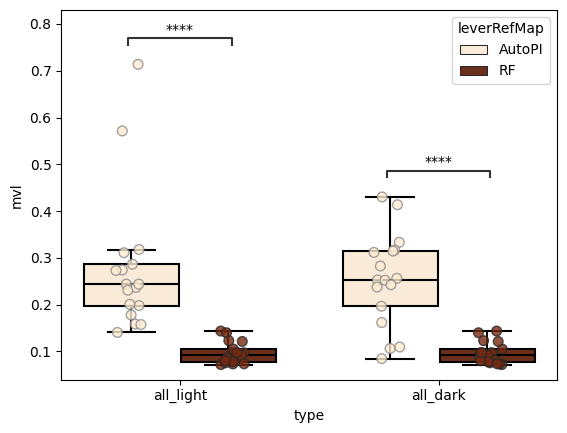

In [39]:
fig, ax =plt.subplots()
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f']
y = 'mvl'

four_custom = [boxPlotColors[0],boxPlotColors[3]] #'#5800ff'
custom_pallet = sns.color_palette(four_custom)

b = sns.boxplot(x="type", y=y, hue="leverRefMap", data=leverRefCombinedG, order = ["all_light",'all_dark'],dodge=True, showfliers = False,hue_order=['AutoPI','RF'],
                 palette = custom_pallet, **boxplot_kwargs)
sns.stripplot(x="type", y=y, hue="leverRefMap", data=leverRefCombinedG, order = ["all_light",'all_dark'],hue_order=['AutoPI','RF'],
                palette = custom_pallet, dodge = True, legend=False,**stripplot_kwargs) #, legend=False

pairs=[[("all_dark", "AutoPI"),("all_dark","RF")],[("all_light", "AutoPI"),("all_light","RF")]]

annotator = Annotator(b, pairs, data=leverRefCombinedG,x='type',y='mvl', hue="leverRefMap",hue_order=['AutoPI','RF'],order = ["all_light",'all_dark'])
annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
annotator.apply_and_annotate()

In [40]:
def boxplot_from_lever_ref_in_rf_and_task(ax,inputDf,y,ylabel):
    four_custom = [boxPlotColors[0],boxPlotColors[3]] #'#5800ff'
    custom_pallet = sns.color_palette(four_custom)
    
    
    b = sns.boxplot(x="type", y=y, hue="leverRefMap", data=inputDf, order = ["all_light",'all_dark'],dodge=True, showfliers = False,hue_order=['AutoPI','RF'],
                    palette = custom_pallet, **boxplot_kwargs)
    sns.stripplot(x="type", y=y, hue="leverRefMap", data=inputDf, order = ["all_light",'all_dark'],hue_order=['AutoPI','RF'],
                    palette = custom_pallet, dodge = True, legend=False,**stripplot_kwargs) #, legend=False

    

    
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel("")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,0.6)
    
    sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.73,0.81),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
    
    pairs=[[("all_dark", "AutoPI"),("all_dark","RF")],[("all_light", "AutoPI"),("all_light","RF")]]


    annotator = Annotator(b, pairs, data=inputDf,x='type',y='mvl', hue="leverRefMap",hue_order=['AutoPI','RF'],order = ["all_light",'all_dark'])
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(["Light","Dark"],rotation= 0,ha = "center",fontsize=GLOBALFONTSIZE)
    
    number = len(inputDf.mouse.unique())
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    ax.set_ylim(0,1)


# Load anchoring strength

In [41]:
fn = myProject.dataPath+"/results/dfBridgeVonMises.csv"

print("Loading",fn)
dfBridgeVonMises = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/dfBridgeVonMises.csv


In [42]:
fn = myProject.dataPath+"/results/dfLeverVonMises.csv"

print("Loading",fn)
dfLeverVonMises = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/dfLeverVonMises.csv


In [43]:
dfBridgeVonMises = dfBridgeVonMises.drop("level_3",axis=1)
dfLeverVonMises = dfLeverVonMises.drop("level_3",axis=1)

In [44]:
dfBridgeVonMises

,condition,session,trialBin,k0,k1,k,mu0,mu1
0,atLever_dark,jp1084-05042022-0107,0,0.450502,0.394618,0.422560,-0.217871,-0.217871
1,atLever_dark,jp1084-05042022-0107,1,0.313752,0.000100,0.156926,0.190724,0.190724
2,atLever_dark,jp1084-05042022-0107,2,0.000100,0.000100,0.000100,-2.079140,-2.079140
3,atLever_dark,jp1084-07042022-0107,0,0.457286,0.618668,0.537977,0.452487,0.452487
4,atLever_dark,jp1084-07042022-0107,1,0.283785,0.315691,0.299738,0.170932,0.170932
...,...,...,...,...,...,...,...,...
877,searchToLeverPath_light,mn8578-25122021-0107,1,1.946292,0.990439,1.468366,2.231556,2.231556
878,searchToLeverPath_light,mn8578-25122021-0107,2,1.736044,0.484608,1.110326,2.034164,2.034164
879,searchToLeverPath_light,mn8599-11022022-0107,0,0.465958,1.469113,0.967535,2.689967,2.689967
880,searchToLeverPath_light,mn8599-11022022-0107,1,0.420235,0.578794,0.499514,0.807549,0.807549


In [45]:
shortConditionNames = {'searchToLeverPath_light': "Search",'searchToLeverPath_dark':"Search",
            'atLever_light':"Lever",'atLever_dark':"Lever", 
            'homingFromLeavingLeverToPeriphery_light':"Homing",
            'homingFromLeavingLeverToPeriphery_dark':"Homing"}

lightNames = {'searchToLeverPath_light': "Light",
            'searchToLeverPath_dark':"Dark",
            'atLever_light':"Light",
            'atLever_dark':"Dark", 
            'homingFromLeavingLeverToPeriphery_light':"Light",
            'homingFromLeavingLeverToPeriphery_dark':"Dark"}

trialBinNames ={0:"Beg.",
          1: "Middle",
          2: "End"}


for df in [dfBridgeVonMises, dfLeverVonMises]:
    df["shortCondition"] = [shortConditionNames[c] for c in df.condition]
    df["light"] = [lightNames[c] for c in df.condition]
    df["trialBinName"] = [trialBinNames[c] for c in df.trialBin]

In [46]:
dfBridgeVonMises["k"] = (dfBridgeVonMises.k0+dfBridgeVonMises.k1)/2
dfBridgeVonMises

,condition,session,trialBin,k0,k1,k,mu0,mu1,shortCondition,light,trialBinName
0,atLever_dark,jp1084-05042022-0107,0,0.450502,0.394618,0.422560,-0.217871,-0.217871,Lever,Dark,Beg.
1,atLever_dark,jp1084-05042022-0107,1,0.313752,0.000100,0.156926,0.190724,0.190724,Lever,Dark,Middle
2,atLever_dark,jp1084-05042022-0107,2,0.000100,0.000100,0.000100,-2.079140,-2.079140,Lever,Dark,End
3,atLever_dark,jp1084-07042022-0107,0,0.457286,0.618668,0.537977,0.452487,0.452487,Lever,Dark,Beg.
4,atLever_dark,jp1084-07042022-0107,1,0.283785,0.315691,0.299738,0.170932,0.170932,Lever,Dark,Middle
...,...,...,...,...,...,...,...,...,...,...,...
877,searchToLeverPath_light,mn8578-25122021-0107,1,1.946292,0.990439,1.468366,2.231556,2.231556,Search,Light,Middle
878,searchToLeverPath_light,mn8578-25122021-0107,2,1.736044,0.484608,1.110326,2.034164,2.034164,Search,Light,End
879,searchToLeverPath_light,mn8599-11022022-0107,0,0.465958,1.469113,0.967535,2.689967,2.689967,Search,Light,Beg.
880,searchToLeverPath_light,mn8599-11022022-0107,1,0.420235,0.578794,0.499514,0.807549,0.807549,Search,Light,Middle


In [47]:
dfLeverVonMises["anchor"] = "Lever"
dfBridgeVonMises["anchor"] = "Bridge"
dfAnchor = pd.concat([dfLeverVonMises,dfBridgeVonMises])
dfAnchor

,condition,session,trialBin,k0,k1,k,mu0,mu1,shortCondition,light,trialBinName,anchor
0,atLever_dark,jp1084-05042022-0107,0,0.000100,0.386615,0.193357,0.499890,0.499890,Lever,Dark,Beg.,Lever
1,atLever_dark,jp1084-05042022-0107,1,0.875837,1.132931,1.004384,-1.234367,-1.234367,Lever,Dark,Middle,Lever
2,atLever_dark,jp1084-05042022-0107,2,1.109553,1.141339,1.125446,-1.011247,-1.011247,Lever,Dark,End,Lever
3,atLever_dark,jp1084-07042022-0107,0,0.502837,0.700210,0.601524,-1.761129,-1.761129,Lever,Dark,Beg.,Lever
4,atLever_dark,jp1084-07042022-0107,1,0.890203,0.243074,0.566639,-1.383773,-1.383773,Lever,Dark,Middle,Lever
...,...,...,...,...,...,...,...,...,...,...,...,...
877,searchToLeverPath_light,mn8578-25122021-0107,1,1.946292,0.990439,1.468366,2.231556,2.231556,Search,Light,Middle,Bridge
878,searchToLeverPath_light,mn8578-25122021-0107,2,1.736044,0.484608,1.110326,2.034164,2.034164,Search,Light,End,Bridge
879,searchToLeverPath_light,mn8599-11022022-0107,0,0.465958,1.469113,0.967535,2.689967,2.689967,Search,Light,Beg.,Bridge
880,searchToLeverPath_light,mn8599-11022022-0107,1,0.420235,0.578794,0.499514,0.807549,0.807549,Search,Light,Middle,Bridge


In [48]:
dfAnchor = dfAnchor[dfAnchor.session.isin(useAble)]

# Final

In [49]:
def plotmap(axes, cluId, maps,showYLabel=True):
    mapindex=gc[gc.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    im=maps['circ80_2'][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99)
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
    

In [50]:
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',showYLabel=True):

    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break
        
    
    im = mapToPlot
    
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')

    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    

In [51]:
def plotLeverMaps(gs, cellDict, interval='all'):
    exampleNumber = 3
    
    gss0 = gridspec.GridSpecFromSubplotSpec(16,6,subplot_spec= gs[:,:])
    
    for j,light in enumerate(["light","dark"]):
        for i,c in enumerate(cellDict[light]["cellIds"]):
            cluId = cellDict[light]["cellIds"][i]
            trialList=cellDict[light]["trialLists"][i]
            mapindex=gc[gc.cluId==cluId].cluId
            mapindex=mapindex.index[0]
            
            if light == 'light':
                borderCo = '#fc8d03'
            else:
                borderCo = '#5950e9'
                
            if i == 0:
                showY=True
            else:
                showY=False
            
            if j != 0:
                showY=False
                
            if j == 0:
                a = i
            else:
                a = i+3
            
            cellName = cluId.split('-')[0]+cluId.split('-')[1]+cluId.split('_')[1]
            
            axes = fig.add_subplot(gss0[1:5, a])
            plotmap(axes,cluId,myMaps,showYLabel=showY)
            if showY:
                axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
            
            axes = fig.add_subplot(gss0[5:9, a])
            spikeOnPathSingleTrial(axes,cluId,trialList, light,borderColor=borderCo)
            
            axes = fig.add_subplot(gss0[9:11, a])
            
            plotAngularMap(axes,leverIFR[cluId]['histo'][f'{interval}_{light}_animalAngleFromLever'],bc=borderCo,showYLabel=showY)
            
            axes = fig.add_subplot(gss0[11:15, a])
                
            plotLeverIFRMatrix(axes,cellId=cluId,light=f'{interval}_{light}',showXLabel=True,sort=True,showYLabel = showY)


In [52]:


def plot_anchoring_strength_box(ax,inputDf,ylabel='',title='',legend=True,ylim=3,legendX=0.7,legendY=0.6,titleName='',pal=None):
    if not pal:
        pal = {
        'Lever':boxPlotColors[0],
        'Room':boxPlotColors[1]
        }
        
    inputDf.replace({'Bridge':'Room'},inplace=True)
    
    b = sns.boxplot(data=inputDf, x= "trialBinName", hue = "anchor",palette = pal,y="k",showfliers=False,**boxplot_kwargs)
    sns.stripplot(data=inputDf, x= "trialBinName", hue = "anchor",y="k",palette = pal, dodge = True, legend=False,**stripplot_kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    
    ax.set_title(titleName,fontsize=GLOBALFONTSIZE)
    
    if title=="Search":
        ax.set_ylim(0,4)
        ax.set_yticks([0,1,2,3,4])
        ax.set_yticklabels([0,1,2,3,4])
    elif title=='At lever':
        ax.set_ylim(0,3)
        ax.set_yticks([0,1,2,3])
        ax.set_yticklabels([0,1,2,3])
        
    ax.set_ylim(0,ylim)
    if legend:  
        sns.move_legend(b, 'lower center',
                    bbox_to_anchor = (legendX,legendY),
                    ncol=1,
                    title=None,
                    frameon=False,
                    fontsize = GLOBALFONTSIZE)
        
    else:
        ax.legend().set_visible(False)
    
    pairs=[[("Beg.","Lever"),("Beg.","Room")],[("Middle","Lever"),("Middle","Room")],[("End","Lever"),("End","Room")]]

    annotator = Annotator(b, pairs, x="trialBinName", y='k', hue="anchor", data=inputDf)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    number = len(inputDf.session.unique())
    
    ax.text(0.07,0.96, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    
        
    

In [53]:
shuffleHolder = []
sesHolder = []
light_condition = 'atLever_light'
for s in shuffleData.keys():
    sd = shuffleData[s][light_condition]['shuffled']
    shuffleHolder.append(sd)
    sesHolder.append(s)
        
    
shuffleLightDf = pd.DataFrame(np.array(shuffleHolder).T,columns=sesHolder)
longDf = shuffleLightDf.melt(var_name = 'Session', value_name = 'Values')
longDf['Session'] = longDf['Session'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
                                                
percentile_95 = np.percentile(longDf['Values'],95)

In [54]:
valueHolder = []                                      
for s in shuffleData.keys():
    ak = shuffleData[s][light_condition]['predicted']
    valueHolder.append(ak)

In [55]:
def create_color_mapping(session_list, color='#d9d9d9'):
    color_mapping = {session: color for session in session_list}
    return color_mapping

def get_shuffle_map(ax, condition = 'atLever_dark',title='',legend=False,customLegend=True,xlim=2.7,ylabel=''):
    shuffleHolder = []
    sesHolder = []
    light_condition = condition
    for s in shuffleData.keys():
        sd = shuffleData[s][light_condition]['shuffled']
        shuffleHolder.append(sd)
        sesHolder.append(s)
        
    color_mapping = create_color_mapping(sesHolder)

    color_palette = sns.color_palette([color_mapping[s] for s in shuffleData.keys()])

    shuffleLightDf = pd.DataFrame(np.array(shuffleHolder).T,columns=sesHolder)
    longDf = shuffleLightDf.melt(var_name = 'Session', value_name = 'Values')
    longDf['Session'] = longDf['Session'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])

    b = sns.histplot(data=longDf,x='Values', hue='Session',multiple='stack',palette = color_palette,alpha=1,legend=legend)

    percentile_95 = np.percentile(longDf['Values'],95)

  
    for s in shuffleData.keys():
        ak = shuffleData[s][light_condition]['predicted']
        c = '#00afb9'
        ax.axvline(x=ak, ymax=0.8, color=c, linestyle='-',lw=1.5)
        
    ak_list = [shuffleData[s][light_condition]['predicted'] for s in shuffleData.keys()]
    # Count how many 'ak' values are above the 95th percentile
    count_above = sum(1 for ak in ak_list if ak > percentile_95)
    total = len(ak_list)

    print(f"{count_above} out of {total} are above the 95th percentile for {condition}")
        
    ax.axvline(x = percentile_95, color = '#f07167', linestyle='--',lw=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
    ax.set_xlabel('Anchoring strength',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    
    ax.set_xlim(0,xlim)
    ax.set_ylim(0,1000)
    ax.set_yticks([0,1000])
    ax.set_yticklabels(['0','1k'])
    
    
    if legend:
        pass
        
    if customLegend:
        legend_labels = ['Shuffled','95% Perc.','Observed']
        legend_colors = ['#d9d9d9','#f07167','#00afb9']
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (0.8,0.5))
        
    
        

In [56]:
df_HDInfo[(df_HDInfo.light == 'all_light')&(df_HDInfo.shuffle)]

,Info_score,HD_score,HD_peakrate,cluid,Info_pc,HD_pc,peak_pc,light,shuffle,sessionName,mouse
0,0.277014,0.018806,37.317170,mn8578-30112021-0107_20,NaN,NaN,NaN,all_light,True,mn8578-30112021-0107,mn8578
1,1.008080,0.051572,18.293439,mn8578-30112021-0107_22,NaN,NaN,NaN,all_light,True,mn8578-30112021-0107,mn8578
2,7.696547,0.998844,0.194017,mn8578-30112021-0107_45,NaN,NaN,NaN,all_light,True,mn8578-30112021-0107,mn8578
3,5.075180,0.381281,1.606702,mn8578-30112021-0107_48,NaN,NaN,NaN,all_light,True,mn8578-30112021-0107,mn8578
4,2.346731,0.096101,4.229555,mn8578-30112021-0107_57,NaN,NaN,NaN,all_light,True,mn8578-30112021-0107,mn8578
...,...,...,...,...,...,...,...,...,...,...,...
10845,1.799001,0.064134,4.643397,jp499-25052023-0108_523,NaN,NaN,NaN,all_light,True,jp499-25052023-0108,jp499
10846,0.566661,0.023311,17.860883,jp499-25052023-0108_528,NaN,NaN,NaN,all_light,True,jp499-25052023-0108,jp499
10847,0.498496,0.031475,26.515002,jp499-25052023-0108_530,NaN,NaN,NaN,all_light,True,jp499-25052023-0108,jp499
10848,0.885490,0.036298,12.064093,jp499-25052023-0108_533,NaN,NaN,NaN,all_light,True,jp499-25052023-0108,jp499


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_color_ring(ax): #Need to add this to the axis: subplot_kw={'projection': 'polar'}
    # Define your colors and create a custom colormap
    colors = ['#ff0080', '#3f5efb', '#40e0d0', '#ff8c00', '#ff0080']
    cmap = LinearSegmentedColormap.from_list('custom', colors)

    # Specify angles and radii for the circle ring
    angles = np.linspace(0, 2 * np.pi, 360) # Divide the circle into 360 degrees
    radii = np.ones(360)*2 # Set radii to 1 for a ring

    # Plot the circle ring with the specified colors based on angles
    ax.scatter(angles, radii, c=angles, cmap=cmap, s=50)

    # # Set the direction of the polar plot to clockwise
    ax.set_theta_direction(1) # Clockwise direction
    ax.set_theta_offset(np.pi) # Set 0 degrees to the top

    # # Remove the axis labels and grid
    ax.set_xticks([]) # Remove angle labels
    ax.set_yticks([]) # Remove radius labels

    ax.set_ylim(0, 2)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)

    # Set the aspect ratio to equal for a circular plot
    ax.set_aspect('equal')
    
    ax.set_title('Angle\nto lever',fontsize=GLOBALFONTSIZE-1)

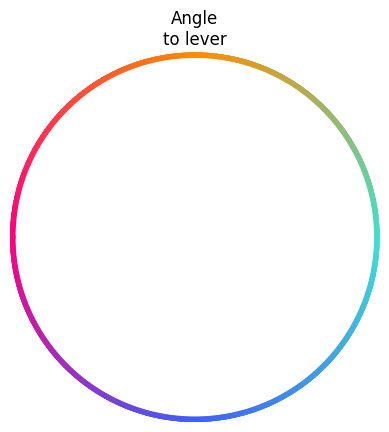

In [58]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plot_color_ring(ax)

In [59]:
error_name = 'r'    
def mySummary(df):        
    error = np.nanmedian(df[f"{error_name}"])        
    return pd.DataFrame({"r": [error]})

leverMapCorPerMouse = leverMapCor[leverMapCor['cell1'].isin(leverGc['cluId'])].groupby(['mouse','rotation','condition']).apply(mySummary).reset_index()

In [60]:
error_name = 'HD_score'    
def mySummary(df):        
    error = np.nanmedian(df[f"{error_name}"])        
    return pd.DataFrame({"HD_score": [error]})

df_HDInfoPerMouse = df_HDInfo[df_HDInfo['cluid'].isin(leverGc['cluId'])].groupby(['mouse','light','shuffle']).apply(mySummary).reset_index()

In [61]:
def plotLeverMaps(gs, cellDict, interval='all'):
    exampleNumber = 3
    
    gss0 = gridspec.GridSpecFromSubplotSpec(16,6,subplot_spec= gs[:,:])
    
    for j,light in enumerate(["light","dark"]):
        for i,c in enumerate(cellDict[light]["cellIds"]):
            cluId = cellDict[light]["cellIds"][i]
            trialList=cellDict[light]["trialLists"][i]
            mapindex=gc[gc.cluId==cluId].cluId
            mapindex=mapindex.index[0]
            
            if light == 'light':
                borderCo = '#fc8d03'
            else:
                borderCo = '#5950e9'
                
            if i == 0:
                showY=True
            else:
                showY=False
            
            if j != 0:
                showY=False
                
            if j == 0:
                a = i
            else:
                a = i+3
            
            cellName = cluId.split('-')[0]+cluId.split('-')[1]+cluId.split('_')[1]
            
            axes = fig.add_subplot(gss0[1:5, a])
            plotmap(axes,cluId,myMaps,showYLabel=showY)
            
            if showY:
                axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
            
            axes = fig.add_subplot(gss0[5:9, a]) 
            spikeOnPathSingleTrial(axes,cluId,trialList, light,borderColor=borderCo)
            
            axes = fig.add_subplot(gss0[9:11, a])
            plotAngularMap(axes,leverIFR[cluId]['histo'][f'{interval}_{light}_animalAngleFromLever'],bc='#4a4e69',showYLabel=showY) #bc=borderCo
            
            axes = fig.add_subplot(gss0[11:15, a])
            plotLeverIFRMatrix(axes,cellId=cluId,light=f'{interval}_{light}',showXLabel=True,sort=True,showYLabel = showY)

In [62]:
fn = myProject.dataPath+"/results/reconstruction_shuffling.csv"
print('Loading', fn)

shuffleMvtError = pd.read_csv(fn,index_col=0)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/reconstruction_shuffling.csv


In [63]:
def plot_shuffle_distribution(ax0,shuffleDf):
    sns.kdeplot(data=shuffleDf,
                x='mvtDirError',color='gray',fill=None,lw=2,ax=ax0,alpha=0.5)


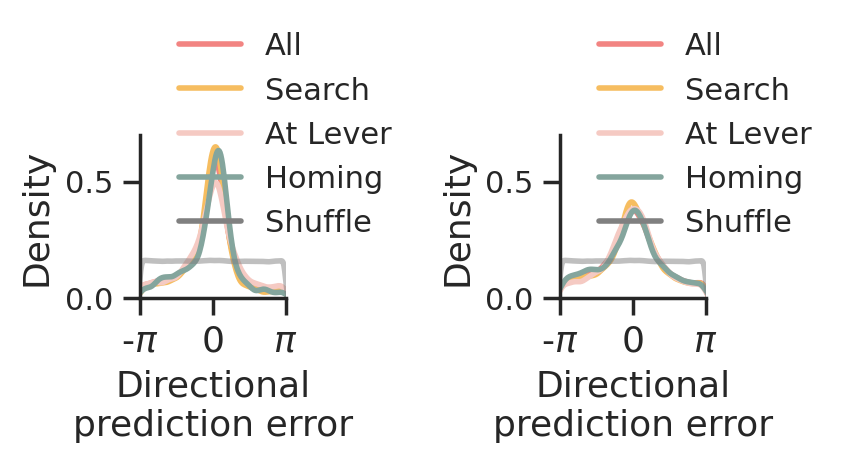

In [64]:
histoDf = allSessionDf[allSessionDf.session.isin(useAble)].copy() #[allSessionDf.session == s]
#Remove NANs
histoDf = histoDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
minSpeed = 10
histoDf = histoDf[(histoDf.speed > minSpeed) ].copy()

histoDf['light'] = histoDf['condition'].apply(lambda x: x.split('_')[1])
histoDf['cond_noLight'] = histoDf['condition'].apply(lambda x: x.split('_')[0])

def plot_histogram_per_condition(ax,plotDf,light='light',colorList=['#F6BD60','#F5CAC3','#84A59D','#F28482','gray'],legend=True,noYaxis = True,legendX = 1,legendY=0.2,ylim=0.7,xlabel='Directional\nprediction error',lw=2,title='',ylabel='Density'):
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'all')&(plotDf.light == light)],x='mvtDirError',color=colorList[0],fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)],x='mvtDirError',color=colorList[1],fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)],x='mvtDirError',color=colorList[2],fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'homingFromLeavingLeverToPeriphery')&(plotDf.light == light)],x='mvtDirError',color=colorList[3],fill=None,lw=lw)
    
    ax.set_title(title,fontsize=GLOBALFONTSIZE)

    light_median = plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)]['mvtDirError'].median()
    dark_median = plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)]['mvtDirError'].median()
    
    ax.set_ylim(0,ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi,np.pi)


    if legend:
        legend_labels = ['All','Search','At Lever','Homing','Shuffle']
        legend_colors = colorList
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (legendX,legendY))
        
    if noYaxis:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])


nrows = 1
ncols = 2
colSize = 2.1
rowSize = 2.1
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = GridSpec(nrows,ncols,figure = fig)

ax = fig.add_subplot(gs[0,0])
plot_histogram_per_condition(ax,histoDf,'light',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D','gray'],noYaxis=False)
plot_shuffle_distribution(ax,shuffleMvtError)

    
ax = fig.add_subplot(gs[0,1])
plot_histogram_per_condition(ax,histoDf,'dark',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D','gray'],noYaxis=False)
plot_shuffle_distribution(ax,shuffleMvtError)

In [65]:
# These two functions below give us the ability to move the ring to the center

In [66]:
def plot_lever_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=False,stack= False,x_shift=0, y_shift=0,
                              simple=False, ylabel = '',customTicks=True,title='',omitYticks=False,omitXTicks=False):
    trialDf = df[df.condition == c].copy()
    if double:
        v0,v1 = get_double_lever_v(trialDf,predicted=predicted)
        
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0_l','v1_l',color_map_hue])
    else:
        v0,v1 = get_lever_v(trialDf,predicted=predicted)
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0_l','v1_l',color_map_hue])
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])
    colorMap = cmap

    x_max = 2 * np.pi + x_shift
    y_max = 2 * np.pi + y_shift
    mask = (vCoordinates.v0 < x_max) & (vCoordinates.v0 >= x_shift) & (vCoordinates.v1 < y_max) & (vCoordinates.v1 >= y_shift)

    # Second mask with a margin of np.pi/2 on each side of the x and y axes
    margin = 0
    x_margin_mask = (vCoordinates.v0 < x_max + margin) & (vCoordinates.v0 >= x_shift - margin)
    y_margin_mask = (vCoordinates.v1 < y_max + margin) & (vCoordinates.v1 >= y_shift - margin)
    

    # Combine the two masks using logical OR (|) to include points in either mask
    combined_mask = mask | (x_margin_mask & y_margin_mask)
        
    a = sns.kdeplot(data=vCoordinates_l,x = 'v0_l',y = 'v1_l',alpha = 1, fill=True, ax = ax)
    if stack:
        a = sns.scatterplot(data=vCoordinates,x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap, ax = ax,legend=False,s = 1)

        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("Grid Coordinate X",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Grid Coordinate Y",fontsize=GLOBALFONTSIZE)
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
    if double:
        d = 'LOOPED'
    else:
        d = ''
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0, 2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        ax.set_title(title,fontsize=GLOBALFONTSIZE)
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        
    if customTicks:
        x_ticks = [x_shift+margin,2*np.pi + x_shift+margin]
        y_ticks = [y_shift+margin,2*np.pi + y_shift+margin]
        
        ax.set_xticks(ticks=x_ticks)
        ax.set_yticks(ticks=y_ticks)
        
        if omitXTicks:
            ax.set_xticks([])
            ax.set_xticklabels([],fontsize=GLOBALFONTSIZE)
        else:
            ax.set_xticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
            
        if omitYticks:
            ax.set_yticks([])
            ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        else:

            ax.set_yticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)


    
        
        ax.set_xlim(x_shift+margin,2*np.pi + x_shift+margin)
        ax.set_ylim(y_shift+margin,2*np.pi + y_shift+margin)

In [67]:
def plot_example_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=True,color_map_hue='leverAngle',simple=False, x_shift=0, y_shift=0, 
                                ylabel = '',customTicks=True,title='',omitYticks=False,omitXTicks=False):
    
    trialDf = df[df.condition == c].copy()
    
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])

    
    
    colorMap = cmap
    
    x_max = 2 * np.pi + x_shift
    y_max = 2 * np.pi + y_shift
    
    mask = (vCoordinates.v0 < x_max) & (vCoordinates.v0 >= x_shift) & (vCoordinates.v1 < y_max) & (vCoordinates.v1 >= y_shift)

    # Second mask with a margin of np.pi/2 on each side of the x and y axes
    margin = 0
    x_margin_mask = (vCoordinates.v0 < x_max + margin) & (vCoordinates.v0 >= x_shift - margin)
    y_margin_mask = (vCoordinates.v1 < y_max + margin) & (vCoordinates.v1 >= y_shift - margin)
    

    # Combine the two masks using logical OR (|) to include points in either mask
    combined_mask = mask | (x_margin_mask & y_margin_mask)
    
    a = sns.scatterplot(data=vCoordinates[mask],x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap,hue_norm=GLOBALHUENORM, ax = ax,legend=False,s = 2,alpha = 1)

    sns.scatterplot(data=vCoordinates[combined_mask],x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap,hue_norm=GLOBALHUENORM, ax = ax,legend=False,s = 2,alpha = 1)
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid Coordinate X")
    ax.set_ylabel("Grid Coordinate Y")
    
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        
    if double:
        d = 'LOOPED'
    else:
        d = ''
    
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else: 
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0, 2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        
        # ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        ax.set_title(title,fontsize=GLOBALFONTSIZE)
        
    if customTicks:
        x_ticks = [x_shift+margin,2*np.pi + x_shift+margin]
        y_ticks = [y_shift+margin,2*np.pi + y_shift+margin]
        
        ax.set_xticks(ticks=x_ticks)
        ax.set_yticks(ticks=y_ticks)
        
        if omitXTicks:
            ax.set_xticks([])
            ax.set_xticklabels([],fontsize=GLOBALFONTSIZE)
        else:
            ax.set_xticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
        
        if omitYticks:
            ax.set_yticks([])
            ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        else:
            ax.set_yticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
        
        ax.set_xlim(x_shift+margin,2*np.pi + x_shift+margin)
        ax.set_ylim(y_shift+margin,2*np.pi + y_shift+margin)

In [68]:
def plotMap(ax,myMap,title="",titleY=0.2,titleFontSize=10,transpose=True,cmap="jet",vmin=0,alpha=1):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(myMap.T,origin="lower",cmap=cmap,interpolation=None, vmin=vmin,alpha=alpha)
    else:
        ax.imshow(myMap,origin="lower",cmap=cmap,interpolation=None, vmin=vmin,alpha=alpha)
    ax.set_title(title,y=titleY,fontsize=titleFontSize,pad=1)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

In [69]:
# Trial by trial comparison
fn = myProject.dataPath+"/results/within_trial_orientation_subtraction.csv"
print('Loading', fn)
withinTrialSubtraction = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/within_trial_orientation_subtraction.csv


In [70]:
def calculate_circular_mean(values):
    # Convert to numpy array for efficiency
    angles = values

    # Calculate mean of sine and cosine components
    mean_sin = np.nanmean(np.sin(angles))
    mean_cos = np.nanmean(np.cos(angles))

    # Compute the circular mean using arctangent
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Adjust the angle to be within -pi to pi 
    if mean_angle > np.pi:
        mean_angle -= 2 * np.pi
    elif mean_angle < -np.pi:
        mean_angle += 2 * np.pi
        
    return mean_angle

groupedPerSession = withinTrialSubtraction.groupby('session').agg({'difference': calculate_circular_mean}).reset_index()

In [71]:
groupedPerSession['mouse'] = groupedPerSession['session'].apply(lambda x: x.split('-')[0])

In [72]:
import scipy
def plot_difference_histogram(ax, inputDf,
                              xlabel='Grid ori. drift at the lever -\nDistance matched ori. drift',
                              ylabel='Trials', c='black', bin_num=5):
    
    # Plot the histogram
    sns.histplot(data=inputDf, x='difference', ax=ax, color=c, bins=bin_num) 

    # Remove top and right spines and set labels and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE-1)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$", "0", "$\pi$"], fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi, np.pi)
    
    # Calculate and print statistics
    stat_val, p_val = scipy.stats.wilcoxon(inputDf['difference'])
    N_num = len(inputDf['difference'])
    print(f'Stats = {stat_val}, p = {round(p_val, 3)}')
    
    # Add a text annotation for the number of trials in axes coordinates
    ax.text(0.05, 0.7, f'N = {N_num}', transform=ax.transAxes, fontsize=GLOBALFONTSIZE)
    
    # Add a vertical dashed line at x=0
    ax.axvline(x=0, linestyle='--', color='black')
    
    # Define arrow endpoints (you can change these values if desired)
    left_arrow_end = -np.pi/1.2   # left arrow endpoint in data coords
    right_arrow_end = np.pi/1.2  # right arrow endpoint in data coords
    y_arrow = 0.83          # y-position in axes fraction (so it stays at the top)
    
    # Draw left arrow (arrow head will be at the left end)
    ax.annotate("",
                xy=(left_arrow_end, y_arrow), xytext=(-0.2, y_arrow),
                xycoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle='->', linestyle='-', color='black', lw=1.2))
    
    # Draw right arrow (arrow head will be at the right end)
    ax.annotate("",
                xy=(right_arrow_end, y_arrow), xytext=(0.2, y_arrow),
                xycoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle='->', linestyle='-', color='black', lw=1.2))
    
    # To place text above the arrows, we use a blended transform 
    # (data for x, axes fraction for y) so that the text stays at a fixed 
    # vertical position relative to the axes.
    from matplotlib.transforms import blended_transform_factory
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    
    # Calculate midpoint positions for the text labels
    left_text_x = (-0.6 + left_arrow_end) / 2
    right_text_x = (0.6 + right_arrow_end) / 2
    text_y = y_arrow + 0.05  # a little above the arrow
    
    ax.text(left_text_x, text_y, "More drift in\nsearch path", transform=transform,
            ha='center', va='bottom', fontsize=GLOBALFONTSIZE-2)
    ax.text(right_text_x, text_y, "More drift in\nat lever path", transform=transform,
            ha='center', va='bottom', fontsize=GLOBALFONTSIZE-2)


Stats = 118.0, p = 0.375


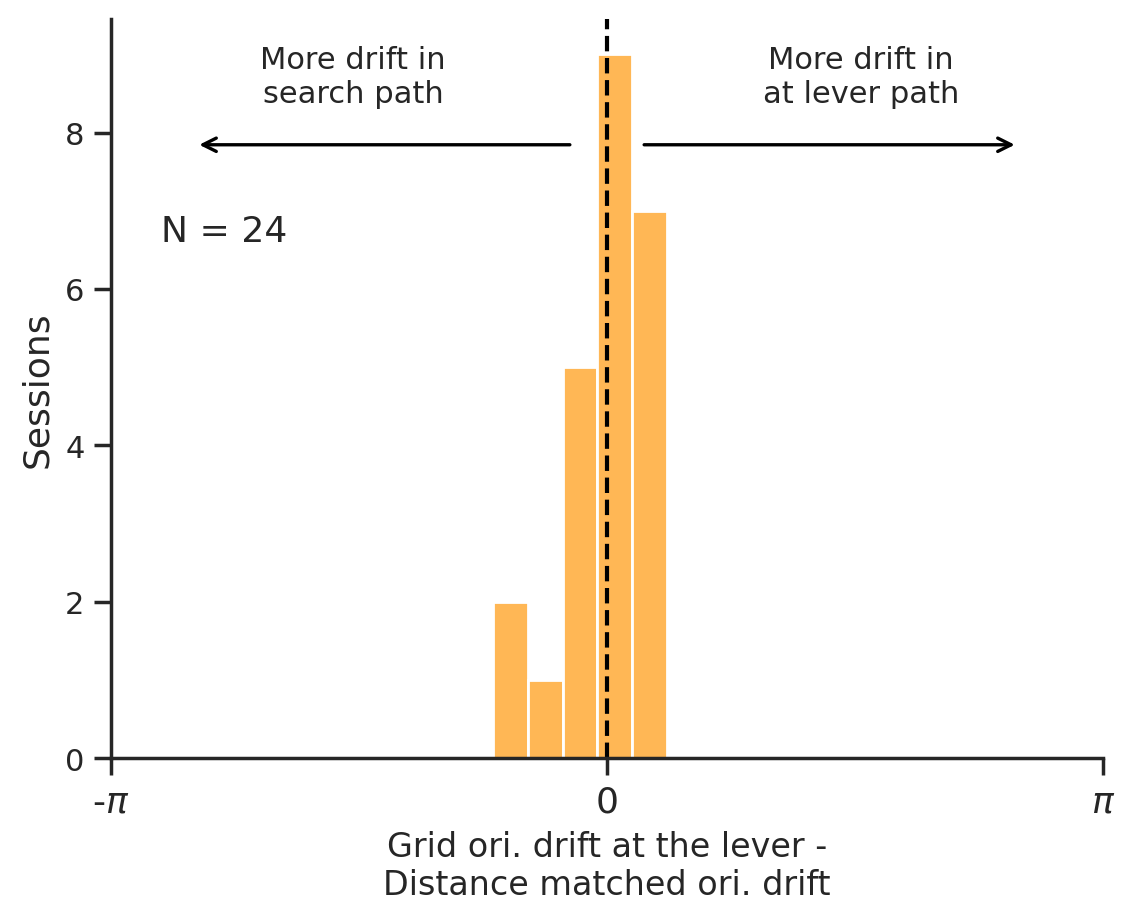

In [73]:
fig, ax0 = plt.subplots()
plot_difference_histogram(ax0,groupedPerSession,ylabel='Sessions',c='#FF9F1C')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all_dark_AutoPI vs. all_dark_RF: Wilcoxon test (paired samples), P_val:7.629e-05 Stat=3.000e+00
all_light_AutoPI vs. all_light_RF: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00


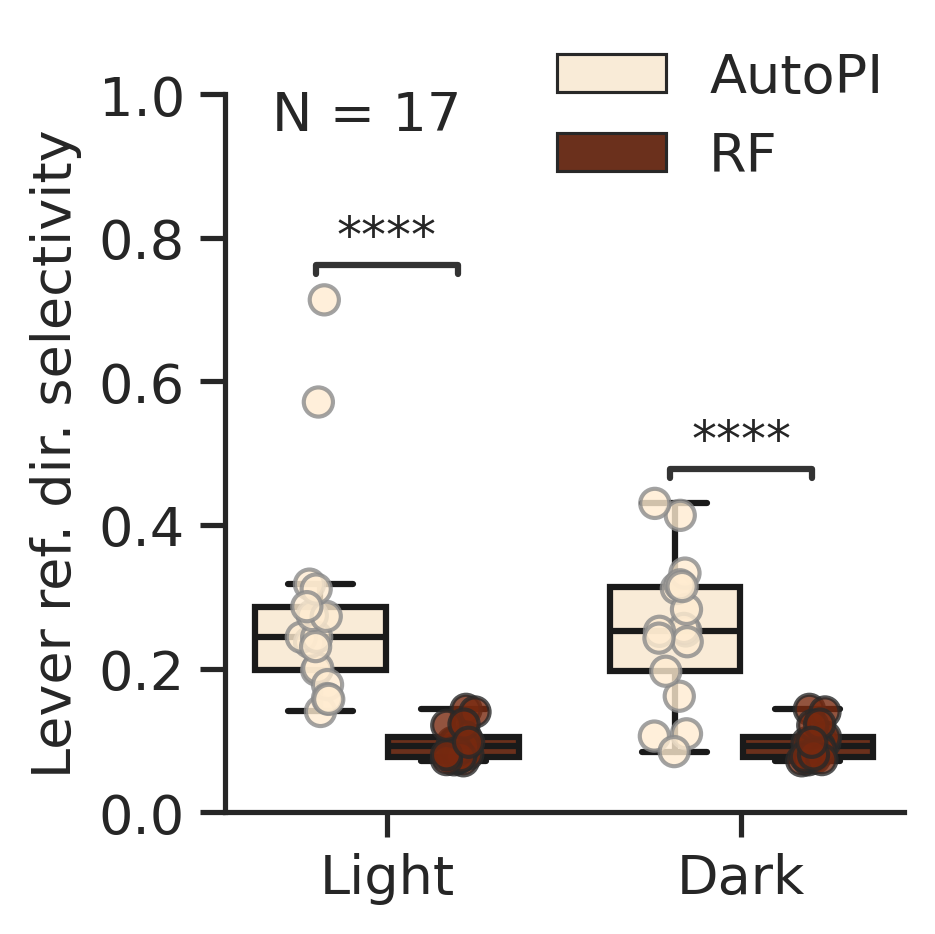

In [74]:
from matplotlib.image import imread

nrows = 1
ncols = 1
colSize = 3
rowSize = 3
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+4,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,

fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig) #,width_ratios=[1]*6+[0.3]+[1] #height_ratios=[1]*4 + [0.2] + [1]*4


ax0 = fig.add_subplot(gs[0,0])
boxplot_from_lever_ref_in_rf_and_task(ax0,leverRefCombinedG,y='mvl',ylabel="Lever ref. dir. selectivity")

ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

In [75]:
GLOBALFONTSIZE = 14

In [76]:
fn = myProject.dataPath+ "/results/myLeverHistos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)

In [77]:
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',showYLabel=True):
    #print(mapindex,mapindex.index)
    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break

    im = mapToPlot
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')

    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

In [78]:
def spikeOnPathCondition(axes,cluId,trialList,light,borderColor = '#000000',condition='light'):
    """
    Plot the spikes on the animal path for some trials
    """
    
    if light == 'light':
        myColorList=['#fc8d03','#fc8d03','#fc8d03']
    elif light == 'dark':
        myColorList=['#5950e9','#5950e9','#5950e9']
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProject.getSession(sessionName)
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
    sSes = [ s for s in sSessions if s.name == sessionName][0]
    getSearchHomingIntervals(ses,sSes)
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    for i,trialNo in enumerate(trialList):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]


        plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor)

        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        #print(inter)
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi
        
        start=[];stop=[]
        for sta,sto in ses.intervalDict[f'atLever_{light}']:
            if sta>=inter[0][0] and sto<=inter[0][1]:
                start.append(sta);stop.append(sto)
        inter2=np.array([[start,stop]]).reshape((-1,2))
        #print(inter2)
        n.spike_train.set_intervals(inter2)
        sSes.ap.set_intervals(inter2)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        
        axes.plot(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color="gray",alpha=0.4)
        axes.scatter(spike_posi[:,0],spike_posi[:,1],color='gray',s=5, alpha=0.2)
        axes.scatter(n.spatial_properties.spike_posi[:,0],n.spatial_properties.spike_posi[:,1],color=myColorList[i],s=12)
        
    axes.set_aspect('equal')
    axes.axis("off")

In [79]:
def spikeOnPathConditionRoomReference(axes,cluId,light,borderColor = '#000000'):
    """
    Plot the spikes on the animal path for some trials
    """
    
    if light == 'light':
        myColorList=['#fc8d03','#fc8d03','#fc8d03']
    elif light == 'dark':
        myColorList=['#5950e9','#5950e9','#5950e9']
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProject.getSession(sessionName)
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
    sSes = [ s for s in sSessions if s.name == sessionName][0]
    getSearchHomingIntervals(ses,sSes)
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    trialList = len(ses.trialList)
    
    trialPlot = []
    for i,trialNo in enumerate(range(0,trialList)):
        if (ses.trialList[trialNo].light == light)&(ses.trialList[trialNo].valid)&(len(ses.trialList[trialNo].journeyList)>0):
            trialPlot.append(trialNo)
            

        
    for i,trialNo in enumerate(trialPlot):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor,lever=False)
  
        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        #print(inter)
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi

        
        axes.scatter(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color='gray',alpha=0.2, s=0.5)

    for i,trialNo in enumerate(trialPlot):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor,lever=False)
   
        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        #print(inter)
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi
        
        
        start=[];stop=[]

        for sta,sto in ses.intervalDict[f'atLever_{light}']:
               if sta>=inter[0][0] and sto<=inter[0][1]:
                       start.append(sta);stop.append(sto)
        
        inter2=np.array([[start,stop]]).reshape((-1,2))
        #print(inter2)
        n.spike_train.set_intervals(inter2)
        sSes.ap.set_intervals(inter2)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        axes.scatter(n.spatial_properties.spike_posi[:,0],n.spatial_properties.spike_posi[:,1],color=myColorList[0],s=0.5)
        
        
    axes.set_aspect('equal')
    axes.axis("off")

In [80]:
uA = ['jp486-19032023-0108', 'jp486-18032023-0108',
       'jp3269-28112022-0108', 'jp486-16032023-0108',
       'jp452-25112022-0110', 'jp486-24032023-0108',
       'jp486-22032023-0108', 'jp452-24112022-0109',
       'jp486-15032023-0108', 'jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108',
       'jp486-20032023-0108', 'jp486-06032023-0108',
       'jp486-26032023-0108', 'jp486-17032023-0108',
       'jp451-29102022-0108', 'jp451-30102022-0108',
       'jp486-10032023-0108', 'jp486-05032023-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107',
       'jp452-23112022-0108', 'jp1686-26042022-0108']

In [81]:
uADf = pd.DataFrame({'session':uA})

In [82]:
uADf['mouse'] = uADf['session'].str.split('-').str[0]

In [83]:
uADf = uADf.sort_values('mouse').reset_index(drop=True)

In [84]:
def plotRateLeverDistance(ax, myLeverHistos,cellIndex,light="all_light",title="",titleY=0.9,showXLabel=True,showTitle=True):
    """
    rate and occupancy histograms as a function of distance from lever
    """
    ax.plot(myLeverHistos[2], myLeverHistos[0][light][cellIndex],c='#ff7d00')
    ax.set_ylabel("Firing rate\n(Hz)",fontsize=GLOBALFONTSIZE)
    if showXLabel:
        ax.set_xlabel("Lever dist.",fontsize=GLOBALFONTSIZE)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,12)
    
    peakRate = np.nanmax(myLeverHistos[0][light][cellIndex])
    ax.text(0.05,0.91,f'Peak rate:{round(peakRate,2)} Hz',fontsize=GLOBALFONTSIZE,transform=ax.transAxes)
    if showTitle:
        ax.set_title(title,y=titleY,fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title('')

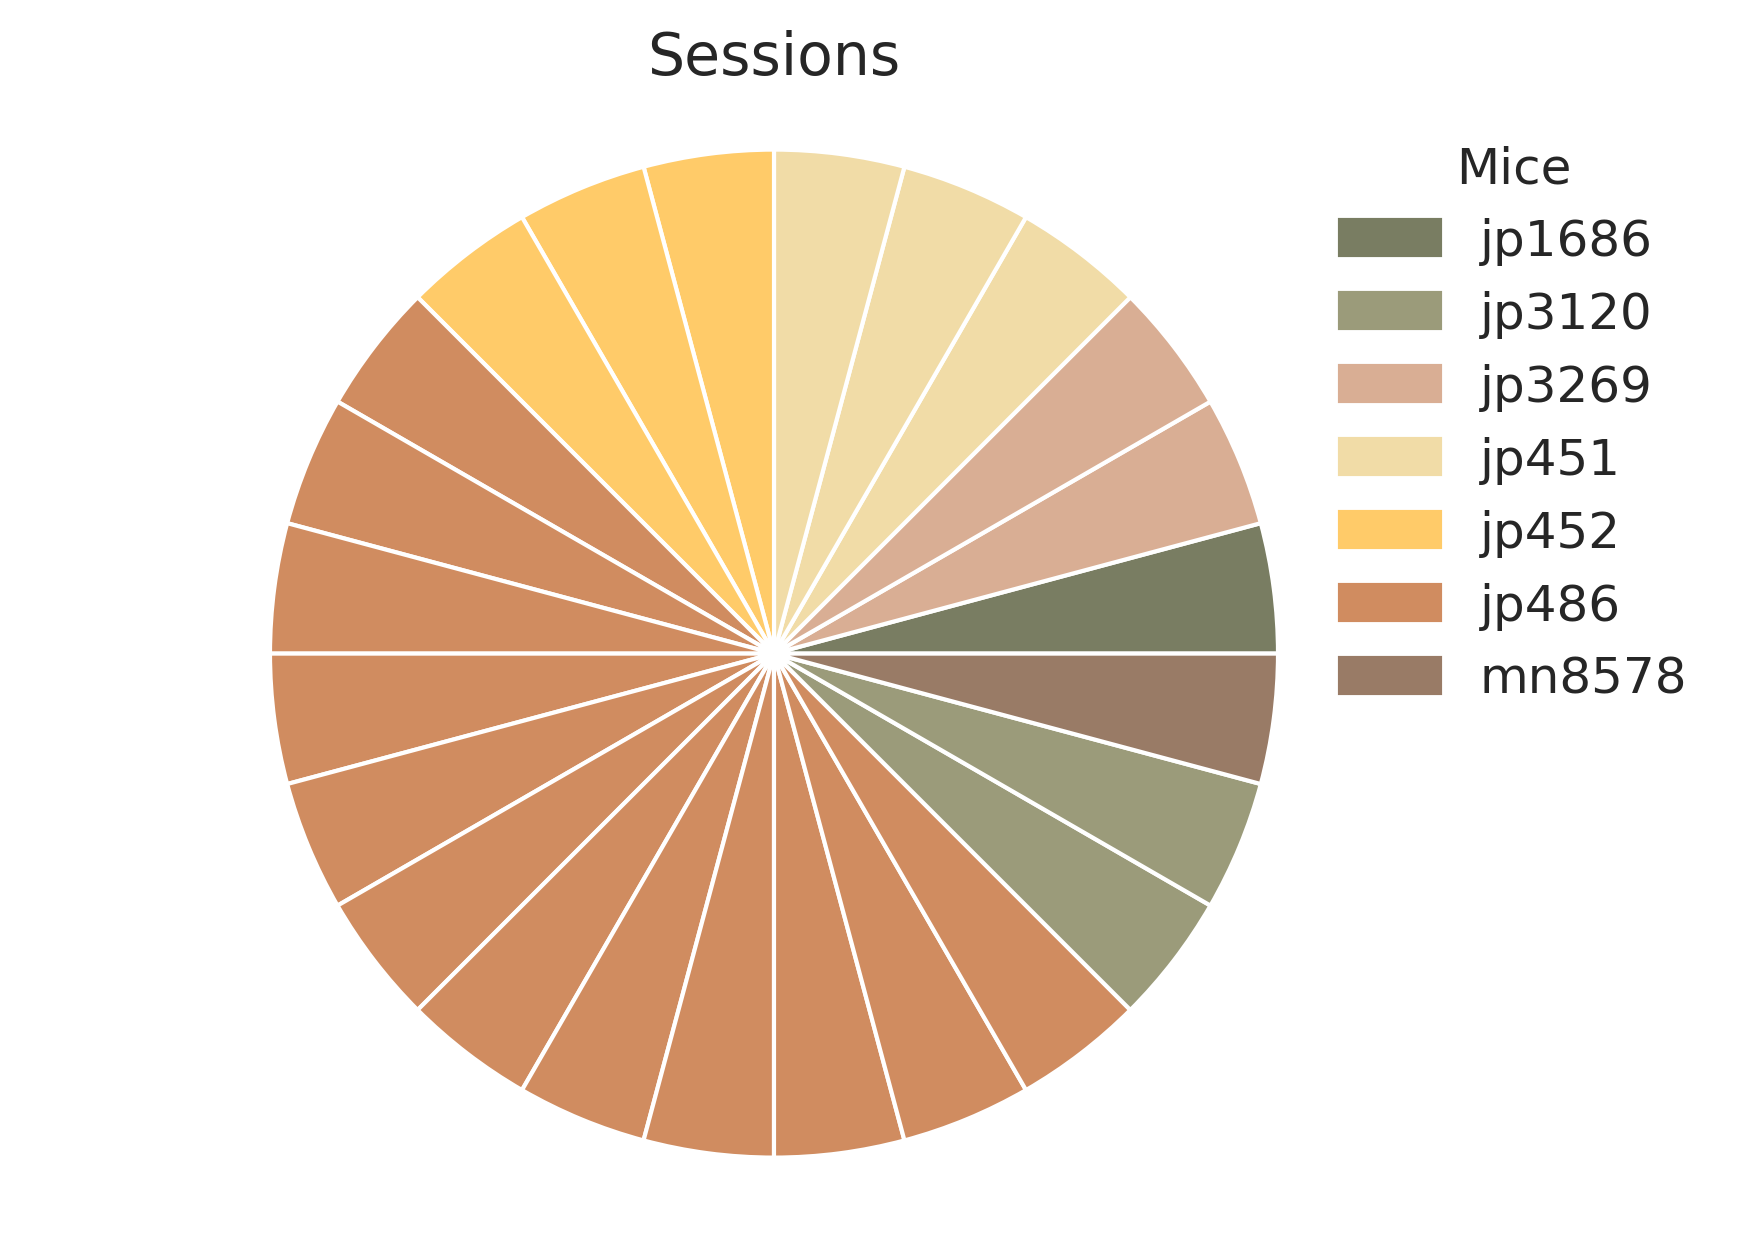

In [85]:
def plot_pie_chart(ax,uADf):
    # Count the occurrences of each session
    session_counts = uADf['session'].value_counts().sort_values()

    # Get unique mice and assign colors
    unique_mice = uADf['mouse'].sort_values().unique()

    colors = ["#797d62", "#9b9b7a", "#d9ae94", "#f1dca7", "#ffcb69", "#d08c60", "#997b66"]  
    mouse_color_map = dict(zip(unique_mice, colors))

    # Map each session to a mouse color
    session_colors = uADf.drop_duplicates('session').set_index('session')['mouse'].map(mouse_color_map)

    # Plot the pie chart
    ax.pie(session_counts, labels=None, colors=[session_colors[session] for session in session_counts.index], autopct=None, wedgeprops={"linewidth": 1, "edgecolor": "white"})

    # Create a legend
    patches = [plt.Rectangle((0,0),1,1, color=mouse_color_map[mouse]) for mouse in unique_mice]

    # Show the plot
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    ax.set_title('Sessions', fontsize=GLOBALFONTSIZE)

def plot_legend(ax,uADf,xV = 0.85, yV = 1):
    unique_mice = uADf['mouse'].sort_values().unique()

    colors = ["#797d62", "#9b9b7a", "#d9ae94", "#f1dca7", "#ffcb69", "#d08c60", "#997b66"]  
    mouse_color_map = dict(zip(unique_mice, colors))

    # Map each session to a mouse color
    session_colors = uADf.drop_duplicates('session').set_index('session')['mouse'].map(mouse_color_map)

    # Create a legend
    patches = [plt.Rectangle((0,0),1,1, color=mouse_color_map[mouse]) for mouse in unique_mice]
    ax.legend(patches, unique_mice, title="Mice",bbox_to_anchor=(xV, yV), loc='upper left',frameon=False,ncols=1, fontsize=GLOBALFONTSIZE-2)

fig, ax =plt.subplots()
plot_pie_chart(ax,uADf)
plot_legend(ax,uADf)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all_dark_AutoPI vs. all_dark_RF: Wilcoxon test (paired samples), P_val:1.526e-04 Stat=3.000e+00
all_light_AutoPI vs. all_light_RF: Wilcoxon test (paired samples), P_val:3.052e-05 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

d1d2_Lever ref. vs. d1d2_Room ref.: Wilcoxon test (paired samples), P_val:3.357e-03 Stat=1.400e+01
l1l2_Lever ref. vs. l1l2_Room ref.: Wilcoxon test (paired samples), P_val:9.399e-01 Stat=6.600e+01
Stats = 29.0, p = 0.47
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Le

/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Lever vs. Middle_Room: Wilcoxon test (paired samples), P_val:9.766e-04 Stat=1.000e+00
Beg._Lever vs. Beg._Room: Wilcoxon test (paired samples), P_val:3.739e-01 Stat=2.300e+01
End_Lever vs. End_Room: Wilcoxon test (paired samples), P_val:1.465e-03 Stat=2.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Lever vs. Middle_Room: Wilcoxon test (paired samples), P_val:5.693e-01 Stat=3.100e+01
Beg._Lever vs. Beg._Room: Wilcoxon test (paired samples), P_val:1.611e-02 Stat=9.000e+00
End_Lever vs. End_Room: Wilcoxon test (paired samples), P_val:3.013e-01 Stat=2.500e+01
saving /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/anchorin

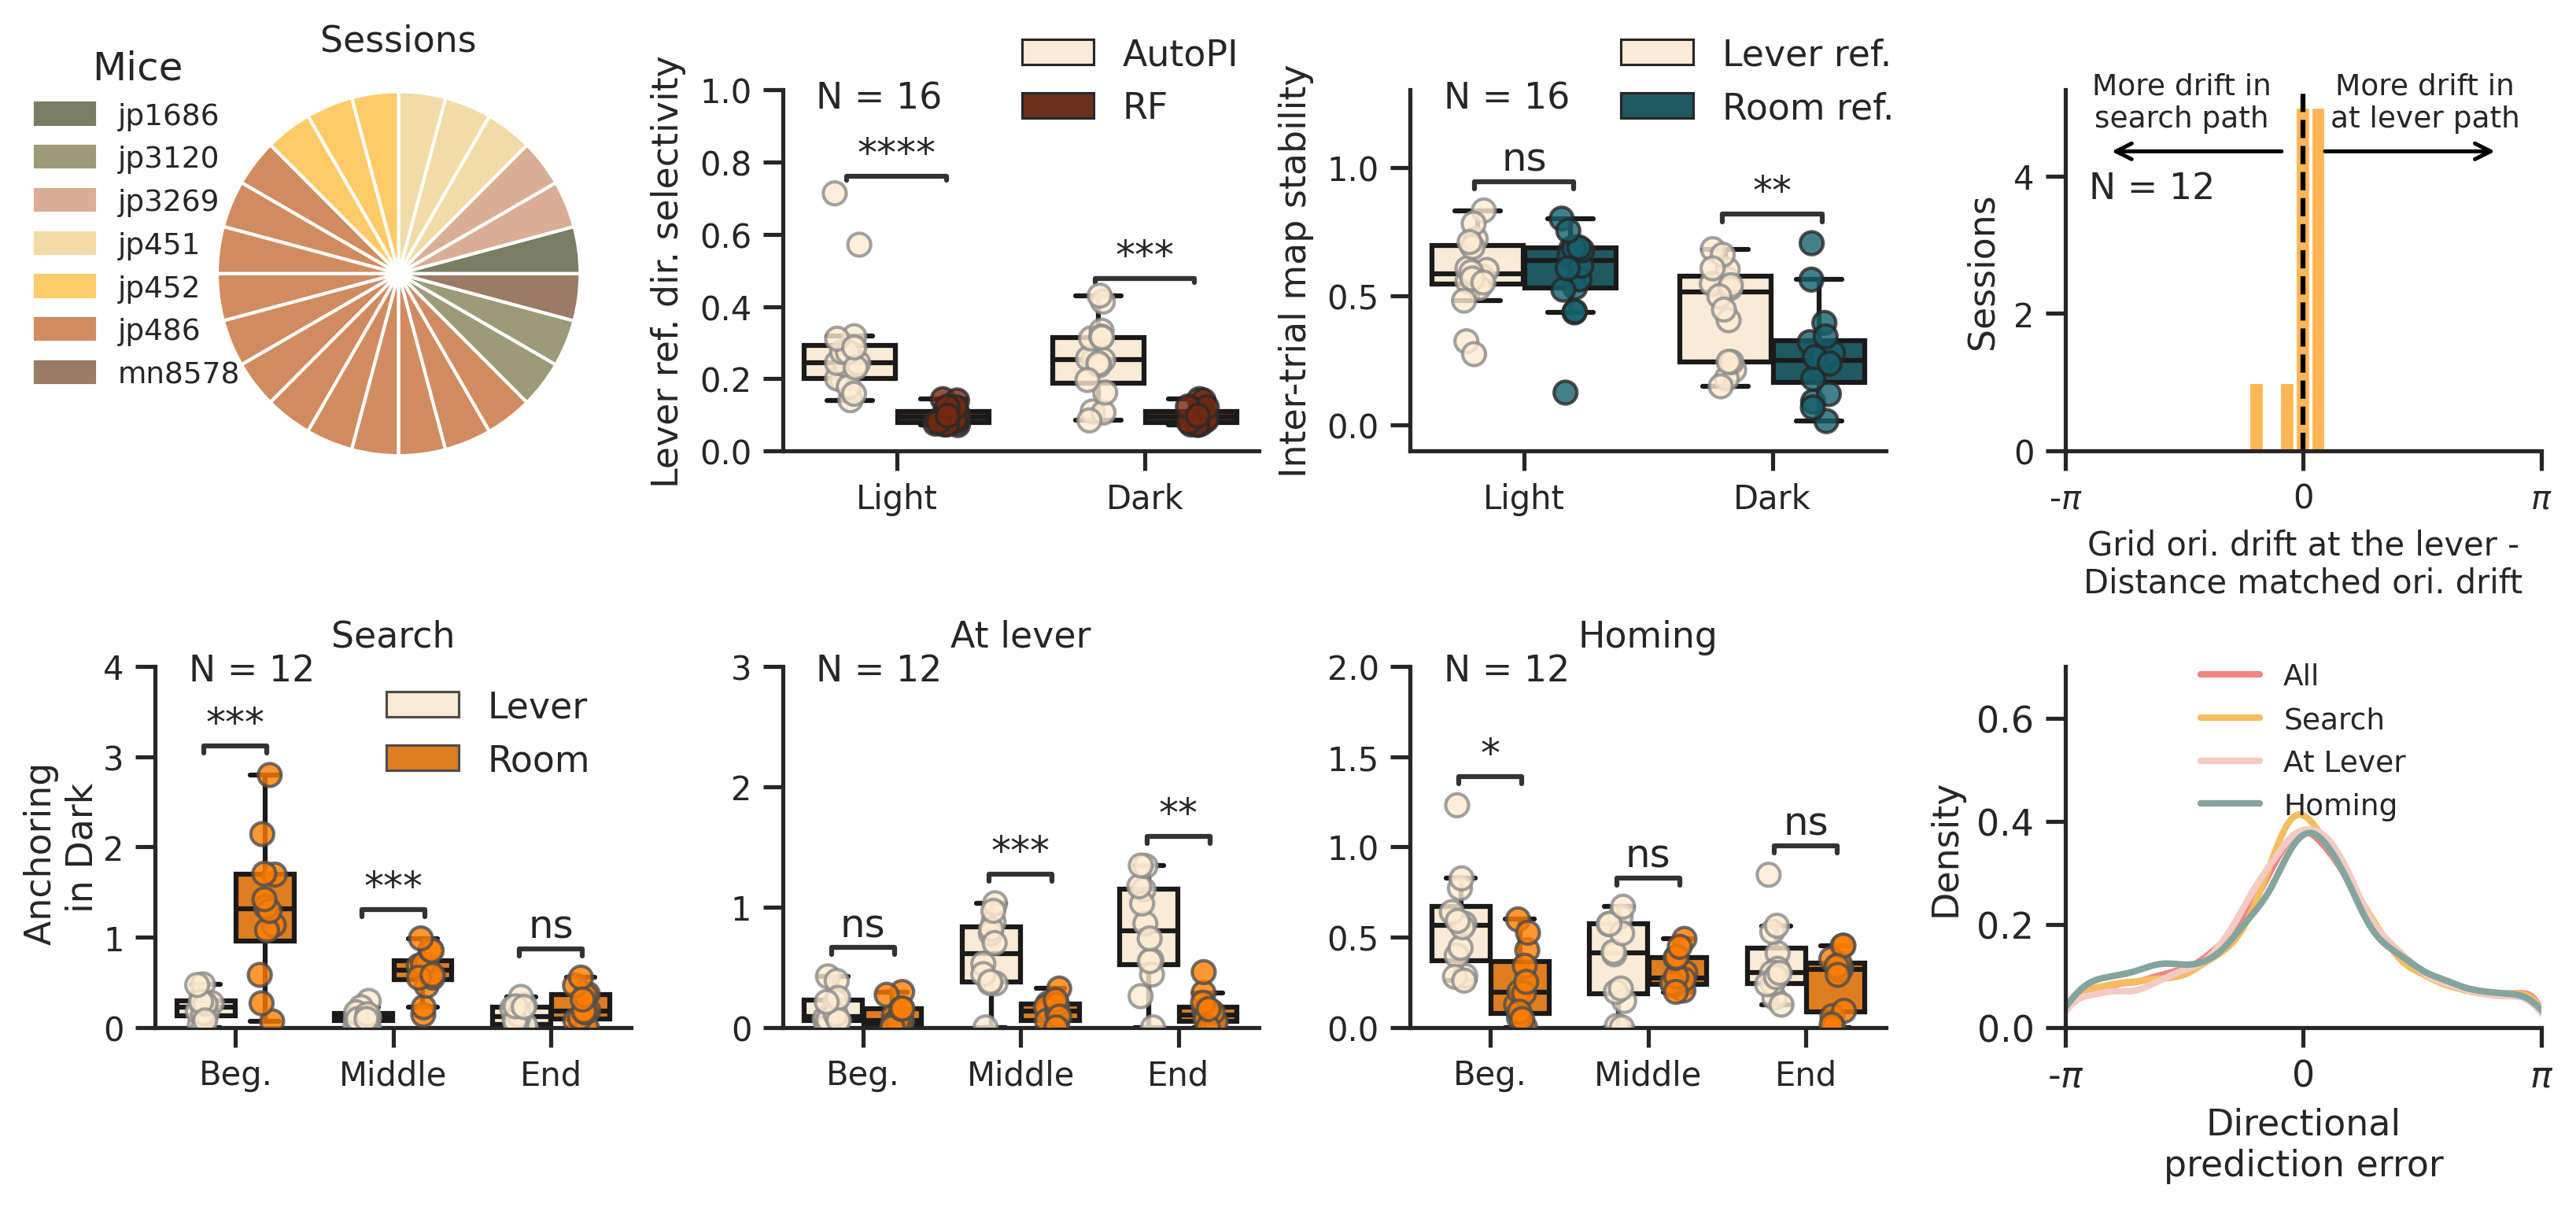

In [86]:
# Make a figure with just the top two rows and save them to plot for latter
GLOBALFONTSIZE = 11
from matplotlib.image import imread
exampleNumber = 3

nrows = 2
ncols = 4
colSize = 2.7
rowSize = 2.5
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+2,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,
#Set the color for this figure


fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig) #,width_ratios=[1]*6+[0.3]+[1] #height_ratios=[1]*4 + [0.2] + [1]*4
gsL = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])


##########################First row################################

gsPie = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec= gs[0,0],height_ratios=[1,0.3],width_ratios=[0.3,1])
ax0 = fig.add_subplot(gsPie[0,1])
plot_pie_chart(ax0,uADf)

gsPL = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])
ax0 = fig.add_subplot(gsPL[0,0])

plot_legend(ax0,uADf,xV=-0.1,yV=1)
ax0.axis('off')

ax0 = fig.add_subplot(gs[0,1])
boxplot_from_lever_ref_in_rf_and_task(ax0,leverRefCombinedG[leverRefCombinedG.mouse != 'jp486'],y='mvl',ylabel="Lever ref. dir. selectivity")
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE-1)

ax0 = fig.add_subplot(gs[0,2])
plot_correlations(ax0,leverMapCorPerMouse[leverMapCorPerMouse.mouse != 'jp486'], showLegend=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE-1)

ax0 = fig.add_subplot(gs[0,3])
##########################Second row################################
histoDf = allSessionDf[allSessionDf.session.isin(useAble)].copy() 
#Remove NANs
histoDf = histoDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
minSpeed = 10
histoDf = histoDf[(histoDf.speed > minSpeed) ].copy() 

histoDf['light'] = histoDf['condition'].apply(lambda x: x.split('_')[1])
histoDf['cond_noLight'] = histoDf['condition'].apply(lambda x: x.split('_')[0])

plot_difference_histogram(ax0,groupedPerSession[groupedPerSession.mouse!='jp486'],ylabel='Sessions',c='#FF9F1C')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE-1)


##########################Second row################################

ax0 = fig.add_subplot(gs[1,0])
light = 'Dark'
condition = 'Search' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]

plot_anchoring_strength_box(ax0,inputDf, ylabel = 'Anchoring \nin Dark', title='Search',ylim=4,titleName='Search')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE-1)

ax0 = fig.add_subplot(gs[1,1])
condition = 'Lever' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]
plot_anchoring_strength_box(ax0,inputDf, title='At lever',legend=False,ylim=3,titleName='At lever')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE-1)


ax0 = fig.add_subplot(gs[1,2])
light = 'Dark'
condition = 'Homing' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]

plot_anchoring_strength_box(ax0,inputDf,legend=False, ylabel = '', title='Homing',ylim=2,legendY=0.62,titleName='Homing')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE-1)

ax0 = fig.add_subplot(gs[1,3])
plot_histogram_per_condition(ax0,histoDf,'dark',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D'],noYaxis=False,legendX=0.5,legendY=0.5,ylim=0.7)

fn = myProject.dataPath+ "/results/anchoring_exclude_jp486_top.png"
print("saving",fn)
plt.savefig(fn,dpi=1200)